In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from WindPy import w
import empyrical
%matplotlib inline

In [3]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2017 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [4]:
start_date, end_date = '2017-04-14', '2020-4-13'

In [9]:
data = w.wsd('004278.OF', 'nav_adj', start_date, end_date)

In [13]:
dfh = pd.DataFrame(np.array(data.Data).T, index=data.Times, columns=['004278'])
dfh.index = pd.to_datetime(dfh.index)

In [17]:
dfh = dfh.drop_duplicates()

In [40]:
empyrical.annual_volatility(dfh.pct_change(), period='weekly')

array([0.08006])

In [41]:
empyrical.max_drawdown(dfh.pct_change())

0   -0.080614
dtype: float64

In [77]:
data = w.wsd('CBA00201.CS,000001.SH,HSI.HI', 'close', start_date, end_date)

In [78]:
bench = pd.DataFrame(np.array(data.Data).T, index=data.Times, columns=data.Codes)

In [79]:
bench_ret = bench.pct_change()

In [80]:
pf_bench = 0.7 * bench_ret['CBA00201.CS'] + 0.2 * bench_ret['000001.SH'] + 0.1 * bench_ret['HSI.HI']

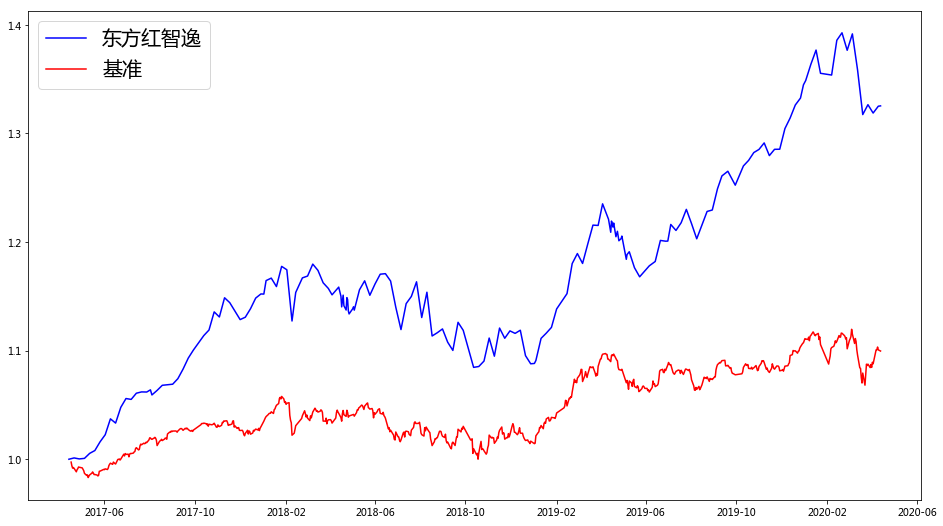

In [81]:
fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(dfh, label='东方红智逸', color='blue')
ax.plot((1 + pf_bench).cumprod(), label='基准', color='red')

ax.legend(fontsize=20)

# 资产配置模型

In [181]:
weight = pd.read_excel('../data/2080_all_wgts.xlsx')
weight = pd.read_excel('../data/3070_all_wgts.xlsx')

In [182]:
weight = weight[weight.index >= start_date]

In [183]:
weight.tail()

,cn_equity_li,cn_bond_li
2020-04-09,0.303000,0.697000
2020-04-10,0.303767,0.696233
2020-04-13,0.301612,0.698388
2020-04-14,0.300557,0.699443
2020-04-15,0.304727,0.695273


In [184]:
pf_aln = weight['cn_bond_li'] * bench_ret['CBA00201.CS'] + weight['cn_equity_li'] * bench_ret['000001.SH']
pf_bench = 0.7 * bench_ret['CBA00201.CS'] + 0.3 * bench_ret['000001.SH']

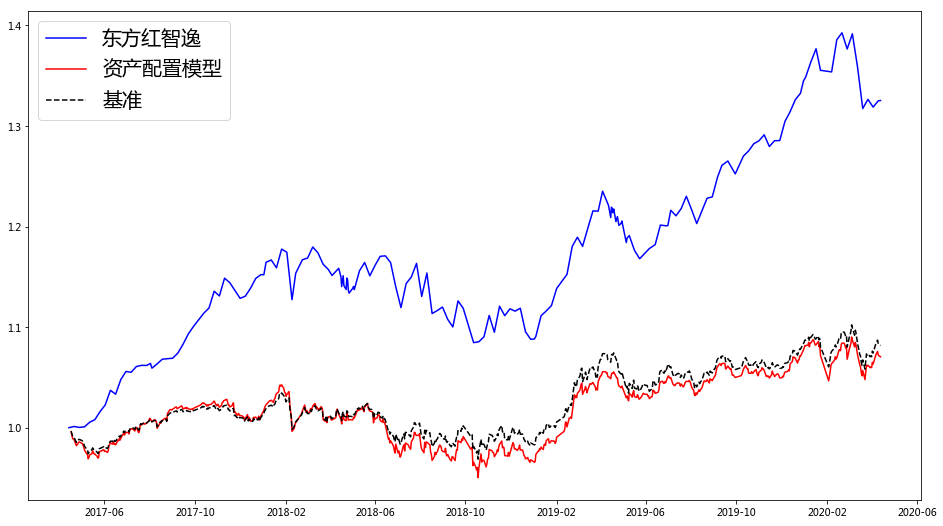

In [185]:
fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(dfh, label='东方红智逸', color='blue')
ax.plot((1 + pf_aln).cumprod(), label='资产配置模型', color='red')
ax.plot((1 + pf_bench).cumprod(), label='基准', color='black', linestyle='--')

ax.legend(fontsize=20)

# 加行业分类

In [186]:
theme = pd.read_excel(u'../data/行业分类表.xlsx', sheet_name=u'中信二级行业2019', skiprows=1)
mv = pd.read_excel(u'../data/行业分类表.xlsx', sheet_name=u'中信二级行业2019市值')

In [187]:
mv[u'行业名称'] = [x.rstrip(u'\(中信\)').rstrip(u'Ⅱ') for x in mv[u'名称']]
mv = mv.set_index(u'行业名称')

In [188]:
columns = [u'金融地产', u'可选周期', u'必选医药', u'信息科技']
returns = {}
for col in columns:
    print(col)
    sectors = theme[col].dropna().tolist()
    codes, weights = [], []
    for s in sectors:
        s = s.rstrip(u'\(中信\)').rstrip(u'Ⅱ')
        if mv.loc[s][u'总市值（亿元）'] > 0:
            codes.append(mv.loc[s][u'代码'])
            weights.append(mv.loc[s][u'总市值（亿元）'])
    weights = np.array(weights)
    weights /= weights.sum()
    data = w.wsd(codes, 'close', start_date, end_date)
    df = pd.DataFrame(np.array(data.Data).T, index=data.Times, columns=codes)
    df = df.pct_change()
    returns[col] = df.mul(weights, axis=1).sum(axis=1)

金融地产
可选周期
必选医药
信息科技


In [189]:
df = pd.DataFrame(returns)
sector_ret = df.mul(np.array([0.3, 0.3, 0.15, 0.25])).sum(axis=1)

In [190]:
pf_sector = weight['cn_bond_li'] * bench_ret['CBA00201.CS'] + weight['cn_equity_li'] * sector_ret

[Text(0,0,'0.90'),
 Text(0,0,'1.00'),
 Text(0,0,'1.10'),
 Text(0,0,'1.20'),
 Text(0,0,'1.30'),
 Text(0,0,'1.40'),
 Text(0,0,'1.50')]

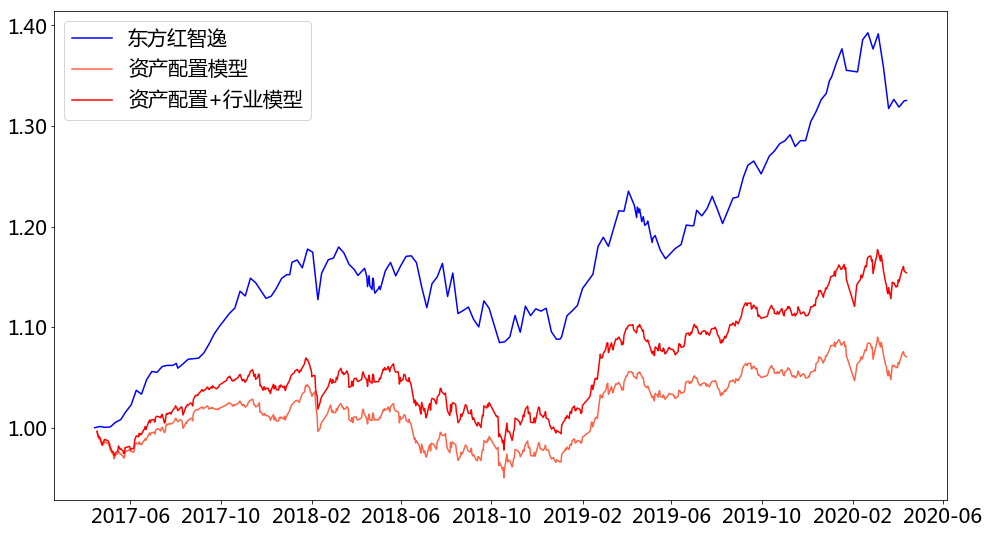

In [191]:
fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(dfh, label='东方红智逸', color='blue')
ax.plot((1 + pf_aln).cumprod(), label='资产配置模型', color='tomato')
ax.plot((1 + pf_sector).cumprod(), label='资产配置+行业模型', color='red')
# ax.plot((1 + pf_bench).cumprod(), label='基准', color='black', linestyle='--')

ax.legend(fontsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.2f}'.format(x) for x in vals])

# 加行业基金

In [192]:
sfund = pd.read_excel('../data/基金池.xlsx', sheet_name='行业')

In [193]:
sfund.head()

,code,name,tag
0,161725.OF,招商中证白酒,可选周期
1,260108.OF,景顺长城新兴成长,可选周期
2,110011.OF,易方达中小盘,可选周期
3,160127.OF,南方新兴消费增长,可选周期
4,005481.OF,银华瑞泰,可选周期


In [194]:
data = w.wsd(sfund['code'].tolist(), 'nav_adj', start_date, end_date)

In [195]:
sfund_nav = pd.DataFrame(np.array(data.Data).T, index=data.Times, columns=data.Codes)

In [196]:
sfund_nav_ret = sfund_nav.pct_change()

In [197]:
data = w.wsd('000914.SH', 'close', start_date, end_date)

In [198]:
fin_df = pd.DataFrame(np.array(data.Data).T, index=data.Times, columns=data.Codes)

In [199]:
fin_ret = fin_df.pct_change()

In [200]:
sector_fund_ret = 0.3 * fin_ret['000914.SH'] + \
             0.3 * sfund_nav_ret[sfund[sfund['tag'] == '可选周期']['code']].mean(axis=1) + \
             0.15 * sfund_nav_ret[sfund[sfund['tag'] == '必选医药']['code']].mean(axis=1) + \
             0.25 * sfund_nav_ret[sfund[sfund['tag'] == '信息科技']['code']].mean(axis=1)

In [201]:
pf_sector_fund = weight['cn_bond_li'] * bench_ret['CBA00201.CS'] + weight['cn_equity_li'] * sector_fund_ret

[Text(0,0,'0.70'),
 Text(0,0,'0.80'),
 Text(0,0,'0.90'),
 Text(0,0,'1.00'),
 Text(0,0,'1.10'),
 Text(0,0,'1.20'),
 Text(0,0,'1.30'),
 Text(0,0,'1.40'),
 Text(0,0,'1.50')]

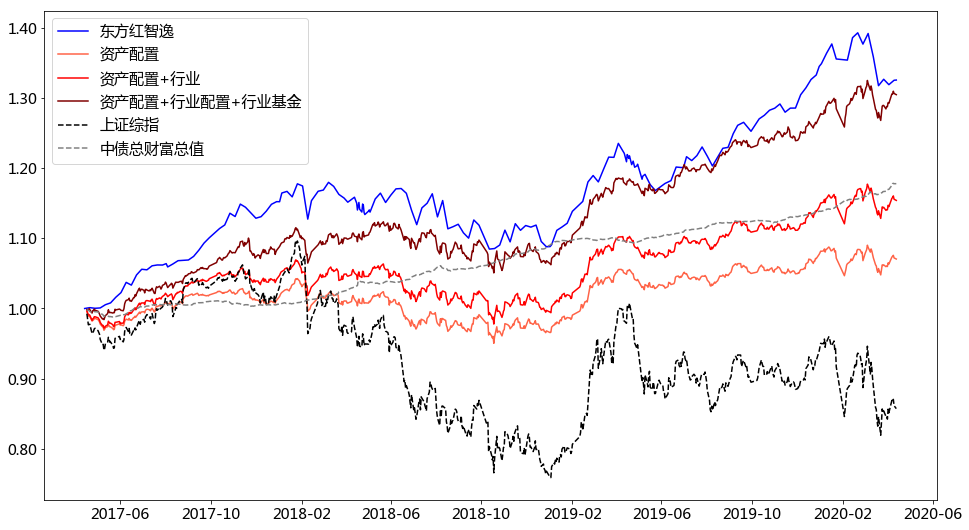

In [202]:
fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(dfh, label='东方红智逸', color='blue')
ax.plot((1 + pf_aln).cumprod(), label='资产配置', color='tomato')
ax.plot((1 + pf_sector).cumprod(), label='资产配置+行业', color='red')
ax.plot((1 + pf_sector_fund).cumprod(), label='资产配置+行业配置+行业基金', color='maroon')
ax.plot((1 + bench_ret['000001.SH']).cumprod(), label='上证综指', color='black', linestyle='--')
ax.plot((1 + bench_ret['CBA00201.CS']).cumprod(), label='中债总财富总值', color='gray', linestyle='--')

ax.legend(fontsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.2f}'.format(x) for x in vals])

# 加全市场基金

In [203]:
fund = pd.read_excel('../data/基金池.xlsx', sheet_name='全市场')

In [204]:
data = w.wsd(fund['code'].tolist(), 'nav_adj', start_date, end_date)

In [205]:
fund_nav = pd.DataFrame(np.array(data.Data).T, index=data.Times, columns=data.Codes)

In [206]:
fund_ret = fund_nav.pct_change()

In [207]:
fund_pf_ret = fund_ret.mean(axis=1)

In [208]:
pf_fund = weight['cn_bond_li'] * bench_ret['CBA00201.CS'] + weight['cn_equity_li'] * fund_pf_ret * 0.5 + weight['cn_equity_li'] * sector_fund_ret

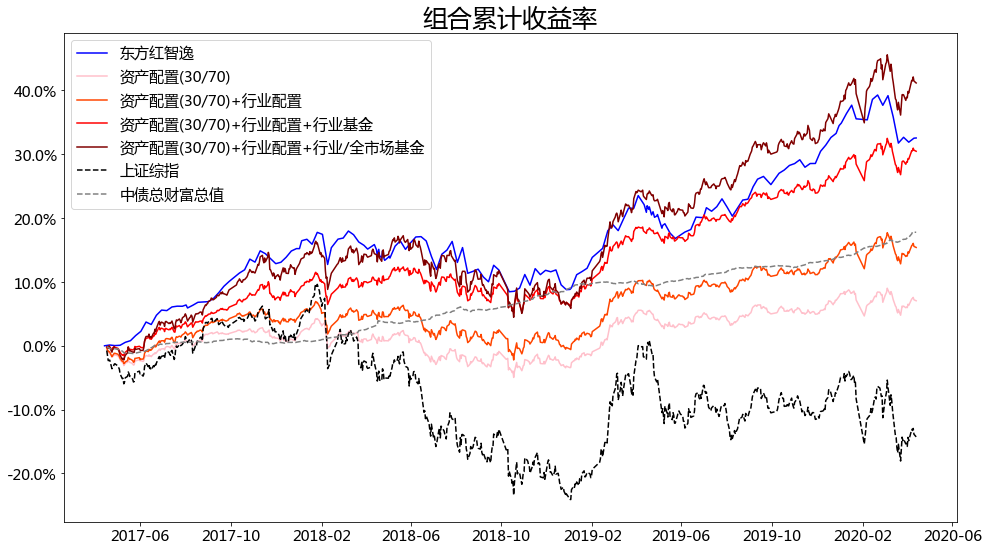

In [209]:
fig, ax = plt.subplots(figsize=(16, 9))

aln_type = '(30/70)'
ax.plot(dfh - 1, label='东方红智逸', color='blue')
ax.plot((1 + pf_aln).cumprod() - 1, label='资产配置%s'%(aln_type), color='pink')
ax.plot((1 + pf_sector).cumprod() - 1, label='资产配置%s+行业配置'%(aln_type), color='orangered')
ax.plot((1 + pf_sector_fund).cumprod() - 1, label='资产配置%s+行业配置+行业基金'%(aln_type), color='red')
ax.plot((1 + pf_fund).cumprod() - 1, label='资产配置%s+行业配置+行业/全市场基金'%(aln_type), color='maroon')
ax.plot((1 + bench_ret['000001.SH']).cumprod() - 1, label='上证综指', color='black', linestyle='--')
ax.plot((1 + bench_ret['CBA00201.CS']).cumprod() - 1, label='中债总财富总值', color='gray', linestyle='--')

ax.legend(fontsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.1f}%'.format(x*100) for x in vals])

_ = ax.set_title('组合累计收益率', fontsize=25, y=1.0)
fig.savefig('../组合累计收益率.png', format='png', dpi=200, bbox_inches='tight')

# 加债券基金

In [210]:
bfund = pd.read_excel('../data/基金池.xlsx', sheet_name='债券')

In [211]:
data = w.wsd(bfund['code'].tolist(), 'nav_adj', start_date, end_date)

In [212]:
bfund_nav = pd.DataFrame(np.array(data.Data).T, index=data.Times, columns=data.Codes)

In [213]:
bfund_ret = bfund_nav.pct_change()

In [214]:
bfund_pf_ret = bfund_ret.mean(axis=1)

In [215]:
pf_bfund = weight['cn_bond_li'] * bfund_pf_ret + weight['cn_equity_li'] * fund_pf_ret * 0.5 + weight['cn_equity_li'] * sector_fund_ret

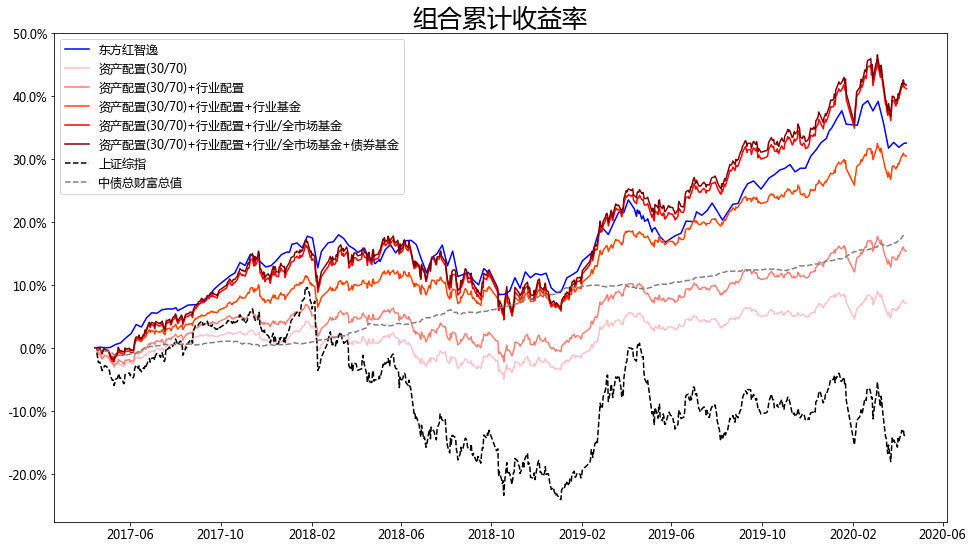

In [217]:
fig, ax = plt.subplots(figsize=(16, 9))

aln_type = '(30/70)'
ax.plot(dfh - 1, label='东方红智逸', color='blue')
ax.plot((1 + pf_aln).cumprod() - 1, label='资产配置%s'%(aln_type), color='pink')
ax.plot((1 + pf_sector).cumprod() - 1, label='资产配置%s+行业配置'%(aln_type), color='salmon')
ax.plot((1 + pf_sector_fund).cumprod() - 1, label='资产配置%s+行业配置+行业基金'%(aln_type), color='orangered')
ax.plot((1 + pf_fund).cumprod() - 1, label='资产配置%s+行业配置+行业/全市场基金'%(aln_type), color='red')
ax.plot((1 + pf_bfund).cumprod() - 1, label='资产配置%s+行业配置+行业/全市场基金+债券基金'%(aln_type), color='maroon')
ax.plot((1 + bench_ret['000001.SH']).cumprod() - 1, label='上证综指', color='black', linestyle='--')
ax.plot((1 + bench_ret['CBA00201.CS']).cumprod() - 1, label='中债总财富总值', color='gray', linestyle='--')

ax.legend(fontsize=12)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.1f}%'.format(x*100) for x in vals])

_ = ax.set_title('组合累计收益率', fontsize=25, y=1.0)
fig.savefig('../组合累计收益率.png', format='png', dpi=200, bbox_inches='tight')

In [218]:
empyrical.annual_return(pf_bfund)

0.12737782022473

In [219]:
empyrical.annual_volatility(pf_bfund)

0.0976882744290598

In [220]:
empyrical.annual_volatility(dfh['004278'].pct_change(), period='weekly')

0.08006000081736221

In [221]:
empyrical.max_drawdown(pf_bfund)

-0.10745314748570724

In [222]:
empyrical.max_drawdown(dfh['004278'].pct_change())

-0.08061371535136042